<a href="https://colab.research.google.com/github/AbigailMRod/GANsDL.AI/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN convolucional profrunda (DCGAN)

En este cuaderno, se creará otro GAN utilizando el conjunto de datos MNIST. Se implementará una GAN convolucional profunda (DCGAN), un modelo GAN muy exitoso e influyente desarrollado en 2015.


<img src="https://miro.medium.com/max/846/1*rdXKdyfNjorzP10ZA3yNmQ.png">

Figura: dibujo arquitectónico de un generador de DCGAN de [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).


## Empezando

####DCGAN
Estas son las características principales de DCGAN:

<!-- ```
Pautas de arquitectura para redes GAN convolucionales profundas estables
• Reemplace cualquier capa de agrupación con convoluciones con estrías (discriminador) y con estrías fraccionadas
circunvoluciones (generador).
• Utilice BatchNorm tanto en el generador como en el discriminador.
• Eliminar capas ocultas totalmente conectadas para arquitecturas más profundas.
• Use la activación de ReLU en el generador para todas las capas excepto para la salida, que usa Tanh.
• Utilice la activación de LeakyReLU en el discriminador para todas las capas.
``` -->


* Usar convoluciones sin capas de agrupación
* Usar la norma de lotes tanto en el generador como en el discriminador
* No usar capas ocultas completamente conectadas
* Usar la activación de ReLU en el generador para todas las capas excepto para la salida, que usa una activación de Tanh.
* Usar la activación de LeakyReLU en el discriminador para todas las capas excepto para la salida, que no usa una activación

Comenzaremos importando algunos paquetes y datos útiles que ayudarán a crear la GAN. También se le proporciona una función de visualizador para ayudar a ver las imágenes que creará la GAN.

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) 


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Función de visualización de imágenes: Dado un tensor de imágenes, número de imágenes y
     tamaño por imagen, traza e imprime las imágenes en una cuadrícula uniforme.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generador
El primer componente que haremos es el generador. Se puede notar que en lugar de pasar la dimensión de la imagen, pasará la cantidad de canales de imagen al generador. Esto se debe a que con DCGAN, utiliza convoluciones que no dependen de la cantidad de píxeles en una imagen. Sin embargo, el número de canales es importante para determinar el tamaño de los filtros.

Construiremos un generador usando 4 capas (3 capas ocultas + 1 capa de salida). 

<!-- Del artículo, sabemos que "[u]sar la norma por lotes tanto en el generador como en el discriminador" y "[u]sar la activación de ReLU en el generador para todas las capas excepto para la salida, que usa Tanh". -->

Al final de la clase de generador, se le proporciona una función de paso hacia adelante que toma un vector de ruido y genera una imagen de la dimensión de salida utilizando su red neuronal. También se le da una función para crear un vector de ruido. Estas funciones son las mismas que las de la última asignación.

<details>
<summary>
<font size="3" color="green">
<b>Sugerencia opcional para <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. Encontrará [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) y [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) útiles!
</details>

In [3]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Clase de generador
     Valores:
         z_dim: la dimensión del vector de ruido, un escalar
         im_chan: el número de canales en las imágenes, ajustado para el conjunto de datos utilizado, un escalar
               (MNIST es en blanco y negro, por lo que 1 canal es su valor predeterminado)
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Construir la red neuronal
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque generador de DCGAN,
         correspondiente a una convolución transpuesta, una norma por lotes (excepto en la última capa) y una activación.
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        # Construir el bloque neuronal
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Función para completar un paso hacia adelante del generador: Dado un tensor de ruido,
         devuelve una copia de ese ruido con ancho y alto = 1 y canales = z_dim.
         Parámetros:
             noise: un tensor de ruido con dimensiones (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Función para completar un paso hacia adelante del generador: Dado un tensor de ruido,
         devuelve las imágenes generadas.
         Parámetros:
             noise: un tensor de ruido con dimensiones (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Función para crear vectores de ruido: Dadas las dimensiones (n_samples, z_dim)
     crea un tensor de esa forma lleno de números aleatorios de la distribución normal.
     Parámetros:
         n_samples: el número de muestras a generar, un escalar
         z_dim: la dimensión del vector de ruido, un escalar
         device: el tipo de dispositivo
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [4]:
'''
Probar la función make_gen_block() 
'''
gen = Generator()
num_test = 100

# Prueba el bloque oculto
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Comprueba que funciona con otras zancadas
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Prueba todo:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Aquí está la prueba para el bloque generador:

In [5]:
# Pruebas unitarias
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## Discriminador
El segundo componente que necesitamos crear es el discriminador.

Utilizará 3 capas en la red neuronal del discriminador. Al igual que con el generador, necesitará crear la función para crear un único bloque de red neuronal para el discriminador.
<!-- Del artículo, sabemos que necesitamos "[u]sar la activación de LeakyReLU en el discriminador para todas las capas". Y para LeakyReLU, "la pendiente de la fuga se estableció en 0,2" en DCGAN. -->
También hay pruebas al final para su uso.
<details>
<summary>
<font size="3" color="green">
<b>Sugerencia opcional para <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. Encontrará [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), y [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) útiles!
</details>

In [6]:
class Discriminator(nn.Module):
    '''
    Clase de discriminador
     Valores:
         im_chan: el número de canales en las imágenes, ajustado para el conjunto de datos utilizado, un escalar
               (MNIST es en blanco y negro, por lo que 1 canal es su valor predeterminado)
     hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque discriminador de DCGAN,
         correspondiente a una convolución, una norma por lotes (excepto en la última capa) y una activación.
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        
        # Construir el bloque neuronal
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Función para completar un pase hacia adelante del discriminador: Dado un tensor de imagen,
         devuelve un tensor de 1 dimensión que representa falso/real.
         Parámetros:
             image: un tensor de imagen aplanado con dimensión (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [7]:
'''
Probar la función make_disc_block() 
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Prueba el bloque oculto
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Prueba el bloque final
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Probar todo
disc_output = disc(test_images)

Aquí hay una prueba para el bloque discriminador:

In [8]:
# Prueba el bloque oculto
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Probar el bloque final

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Probar todo

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Entrenamiento
¡Ahora podemos ponerlo todo junto!
Recuerda que estos son los parámetros:
   * criterion: la función de pérdida
   * n_epochs: la cantidad de veces que itera a través de todo el conjunto de datos durante el entrenamiento
   * z_dim: la dimensión del vector de ruido
   * display_step: con qué frecuencia mostrar/visualizar las imágenes
   * batch_lote: el número de imágenes por paso adelante/atrás
   * lr: la tasa de aprendizaje
   * beta_1, beta_2: el término de impulso
   * device: el tipo de dispositivo

Además, tenga en cuenta que **esto funciona muy lentamente en la CPU predeterminada**. Una forma de ejecutar esto más rápidamente es descargar el .ipynb y subirlo a Google Drive, luego abrirlo con Google Colab, hacer clic en 'Tiempo de ejecución -> Cambiar tipo de tiempo de ejecución' y configurar el acelerador de hardware en GPU y reemplazar
`device = "cpu"`
con
`device = "cuda"`. Luego, el código debería ejecutarse sin más cambios, más de 1000 veces más rápido. 

In [9]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# Una tasa de aprendizaje de 0,0002 funciona bien en DCGAN
lr = 0.0002

# Estos parámetros controlan el impulso del optimizador, sobre el que puede leer más aquí:
# https://distill.pub/2017/momentum/ 
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# Puede transformar los valores de la imagen para que estén entre -1 y 1 (el rango de la activación de tanh)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Luego, se puede inicializar su generador, discriminador y optimizadores.

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Inicializamos los pesos a la distribución normal.
# con media 0 y desviación estándar 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

¡Finalmente, podemos entrenar la GAN!
Para cada época, procesará todo el conjunto de datos en lotes. Para cada lote, actualizará el discriminador y el generador. Entonces, ¡puedes ver los resultados de DCGAN!

Esta es aproximadamente la progresión que debe esperar. En GPU, esto toma alrededor de 30 segundos por cada mil pasos. En la CPU, esto puede tardar unas 8 horas por cada mil pasos. Puede notar que en la imagen del Paso 5000, el generador está produciendo de manera desproporcionada cosas que se parecen. Si el discriminador no aprendió a detectar este desequilibrio lo suficientemente rápido, entonces el generador podría producir más. Como resultado, puede haber terminado engañando tan bien al discriminador que no habría más mejora, lo que se conoce como colapso de modo:
<img src="https://doc-00-8o-docs.googleusercontent.com/docs/securesc/b7lqnqiobbdju95be64fukch83k4etou/7foho9hah2rgjav09qktg935qqavd1ha/1657047525000/16768126786232632622/14449229852641397451/1SvEV3Xz5n1kC48_VG7iehRXdL4g4l1a8?e=view&ax=ACxEAsYFSdqBe2k3UgyOnKaEJEVjyFkaWlSVrcXWjZq7nG2Atuh2jQEAN8rFGcuIEo3VYoxPBL7Q71cb5msNea4jl-wj5jMohM2vgXrUMpt-kQHMlbjwInre06VsFCiaOTomVBXD0KXXL49-X2NZw9201sLeZ9pvWMmwoZnnRcj30hRWqqqOCr-l_eUe4qnfjkLBF1rvctEX0jQq30iUzmntblCemaI6wE62RYUlop4kvyLYciJzAAJYRP6pmy69Uc8-XlpHWvKYZTCjsU49fVtg05FrZwxuyYpoToQ_BkNYXSnJeuuqN7y9FSWEIhgIYlTGHEm5OSn7oeBbTcXjMhOGmnrBFLxwTSvZ1yGZG28eJtax6LM6Auy-860t7JJWXAeedXiM5c-G1yfUapZGD1_AQ7D6SEm8L_xKu-4AWWa3AXzgnImrQJt9v7q3HRFLodNwtjYj99tjs2Fxx8jzwR8-cA7ATYgf4sk_CoPLjc0S0aozREyVnce0eYdpy2fQqenDAoU4fO5PqibbL3pmv-WFGFsKD1wdmzyjTPsU86EaiXcr3umwyMVtSf0pdMr4afDV_WT8mzGTmX3C2kM1BIzJu8JeP9_ha-JsMSKaJoILaFDQEkIIk6CC3BGpcbYKKTGgYAd9IhUeOL_Kemb8UwhriKlDgWuCISeeCx52uSCl2VmjhqUSiGmAWPHsk_G-Ik5QUBWqcCVewUPY-tXd8iNfhlQeJaulo-5oNsSE-ntp_zrSz1mLTu2HaFBavsdzU_6ELW4-vSWbbrDL3lHveZLD&uuid=cfc573a7-3a50-45bd-a91a-e03cca3d6fc6&authuser=0&nonce=ail3ej1gt2lna&user=14449229852641397451&hash=r9ckpjtcjvbd1inpnqa62fu3p3e5rcuq">


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.7001043785810478, discriminator loss: 0.6970971758365634


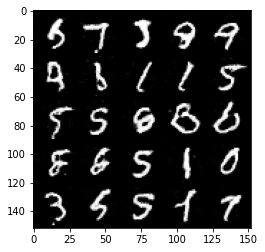

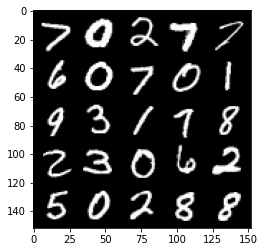

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 0.697663063287735, discriminator loss: 0.6959139088392258


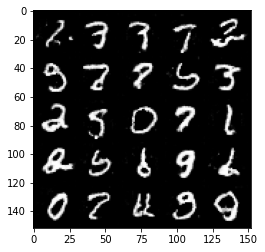

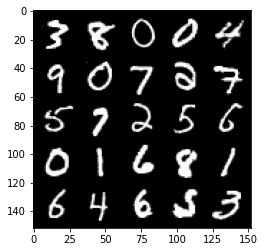

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 0.6952532843351357, discriminator loss: 0.6957515994310376


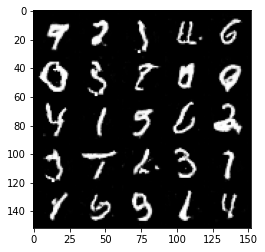

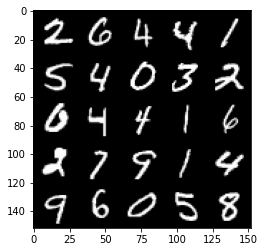

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 0.6964800817966462, discriminator loss: 0.6955678038597101


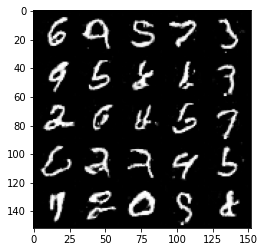

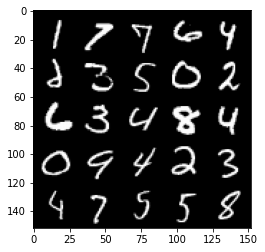

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 0.6964915853738783, discriminator loss: 0.695423637628555


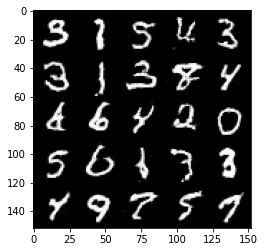

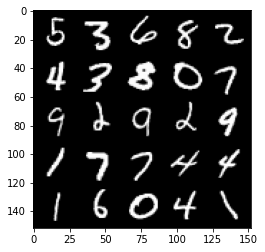

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 0.6965446132421498, discriminator loss: 0.6952483581304556


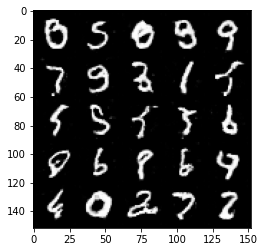

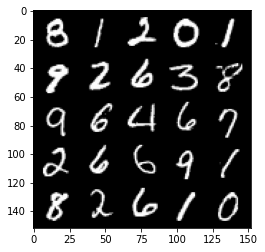

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 0.6963437632322313, discriminator loss: 0.6950303243398661


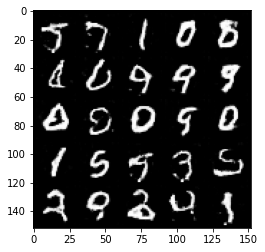

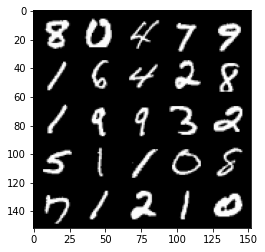

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 0.6965244265794758, discriminator loss: 0.6951803853511813


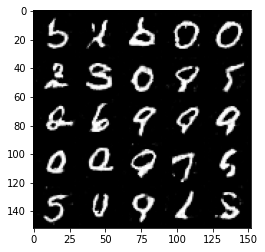

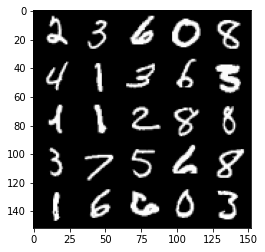

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 0.6964418160915373, discriminator loss: 0.6951987704038611


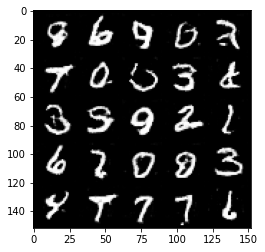

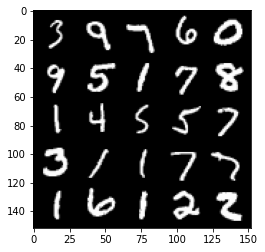

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 0.6956016497612001, discriminator loss: 0.6949257547855375


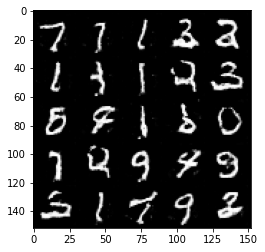

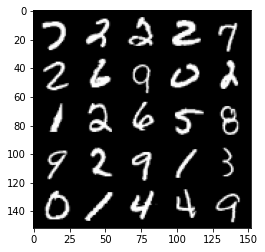

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 0.6964178012609483, discriminator loss: 0.6950184689760204


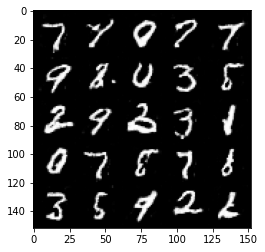

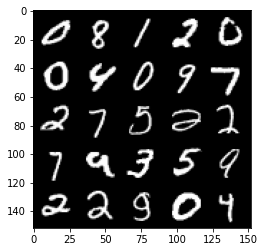

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 0.6954637961387642, discriminator loss: 0.6946487354040138


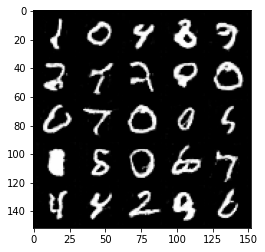

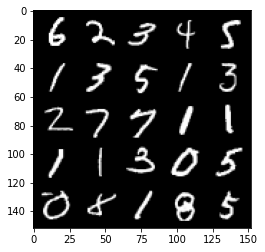

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 0.6952729673385627, discriminator loss: 0.6944680070877075


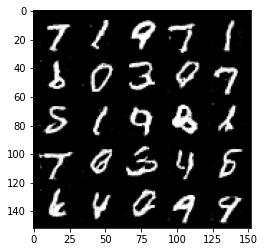

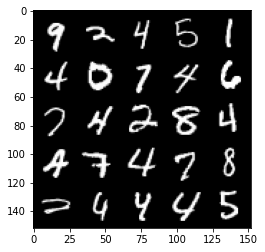

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 0.6954726558923718, discriminator loss: 0.6946900022029874


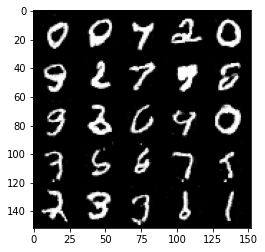

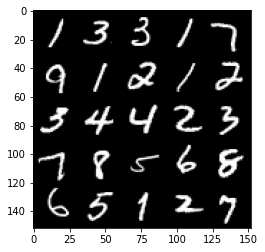

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 0.6952787244319918, discriminator loss: 0.694550950050354


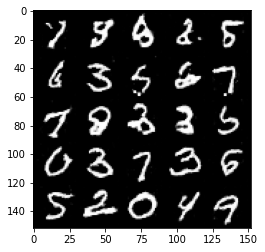

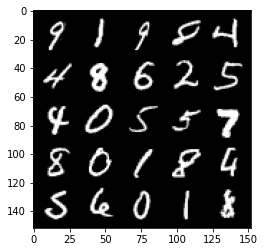

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 0.6964193828105925, discriminator loss: 0.6946671743392943


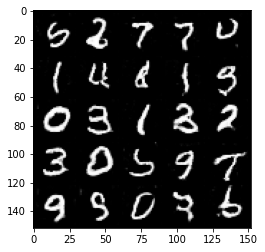

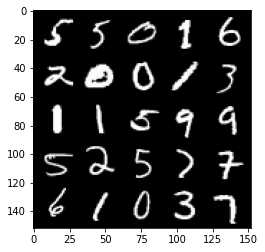

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 0.6952808668613429, discriminator loss: 0.6943355402946466


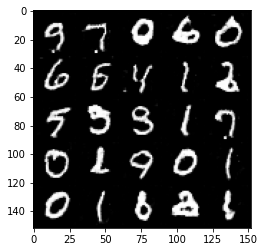

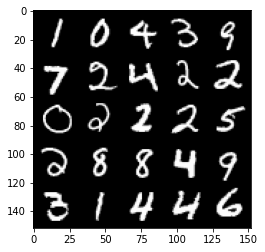

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 0.6948943710327155, discriminator loss: 0.6942300535440448


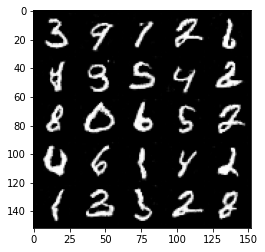

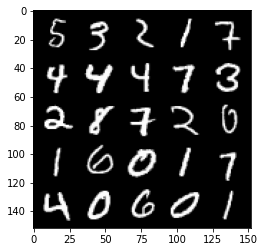

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 0.6957566628456121, discriminator loss: 0.6944595345258715


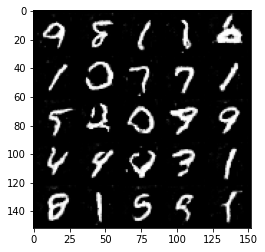

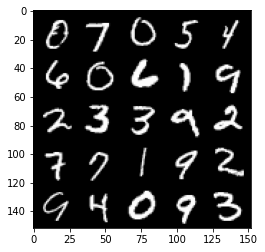

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 0.6951951354742056, discriminator loss: 0.694229327797889


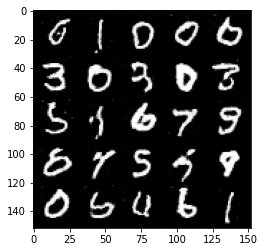

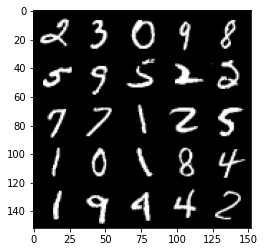

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 0.6947823520898818, discriminator loss: 0.6941025984287267


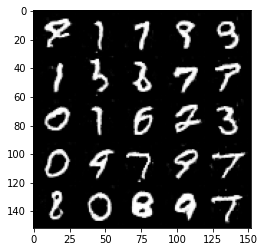

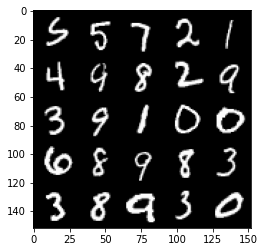

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 0.6949090560674669, discriminator loss: 0.6940678011178976


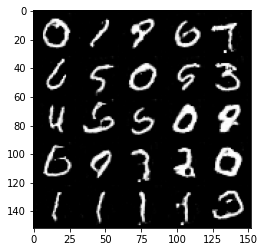

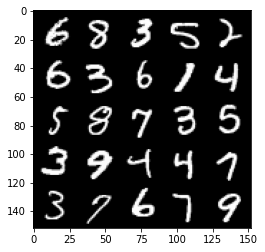

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 0.6947906309366226, discriminator loss: 0.6941332590579987


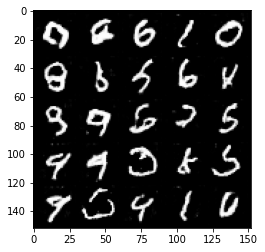

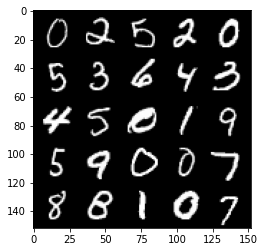

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 0.6950015004873273, discriminator loss: 0.6940541312694548


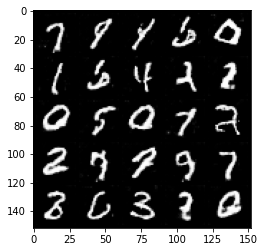

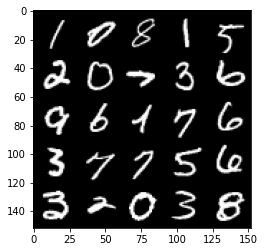

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 0.6946566917896273, discriminator loss: 0.6940286986827849


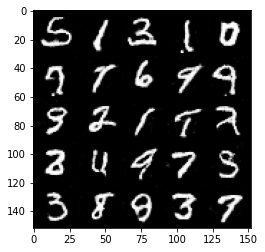

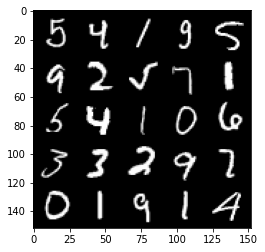

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 0.6955373084545143, discriminator loss: 0.6940932449102393


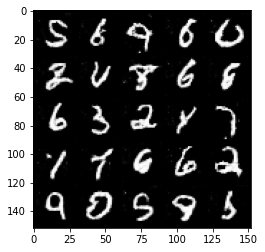

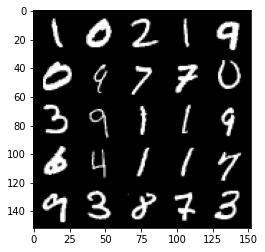

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 0.694300619363785, discriminator loss: 0.6939233882427216


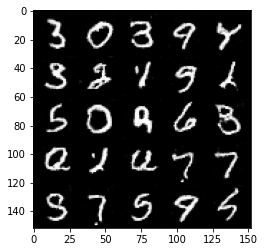

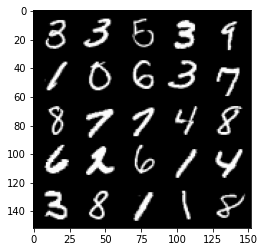

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 0.695106753587723, discriminator loss: 0.6939745552539819


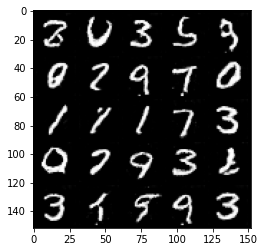

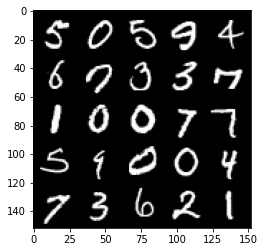

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 0.6941476888656612, discriminator loss: 0.6938172466754909


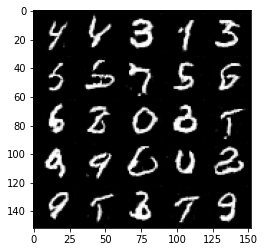

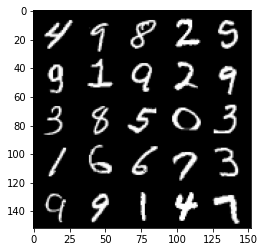

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 0.6943658711910243, discriminator loss: 0.6939343861341468


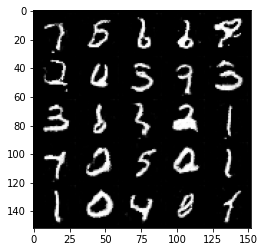

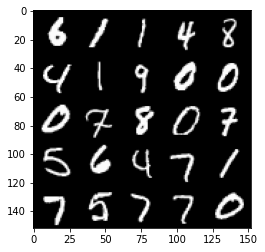

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 0.6949851995706561, discriminator loss: 0.6940037387609481


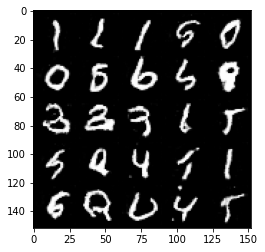

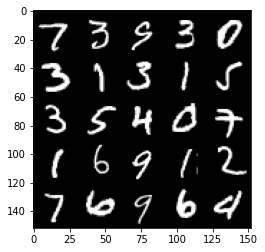

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34, step 16000: Generator loss: 0.6946672856807712, discriminator loss: 0.6939160506725317


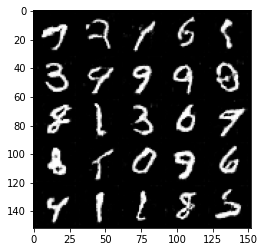

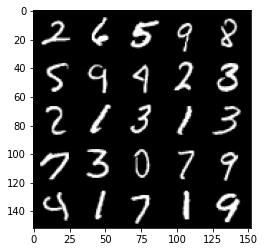

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35, step 16500: Generator loss: 0.6944290708303448, discriminator loss: 0.6938875495195382


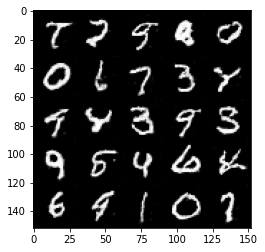

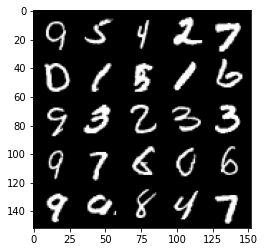

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36, step 17000: Generator loss: 0.6945137791633609, discriminator loss: 0.6937285934686653


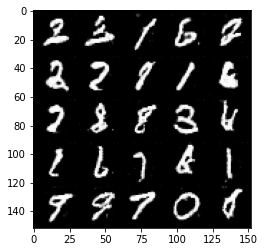

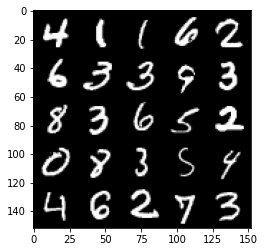

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37, step 17500: Generator loss: 0.6946178243160255, discriminator loss: 0.6937139720916741


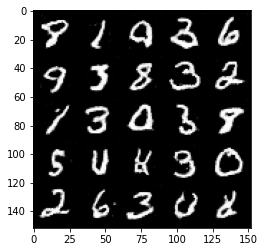

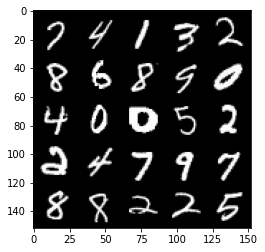

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38, step 18000: Generator loss: 0.6933069970607765, discriminator loss: 0.6938201123476033


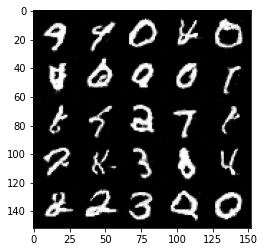

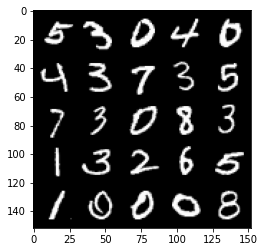

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39, step 18500: Generator loss: 0.6945240442752838, discriminator loss: 0.6937737017869952


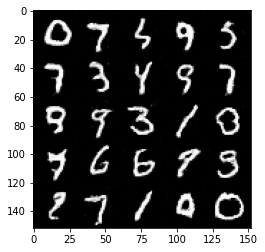

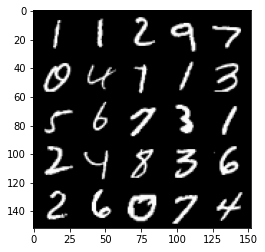

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40, step 19000: Generator loss: 0.6941308763027191, discriminator loss: 0.6937513592243187


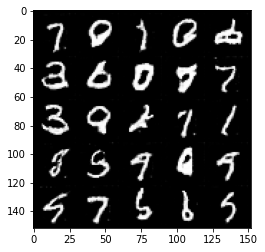

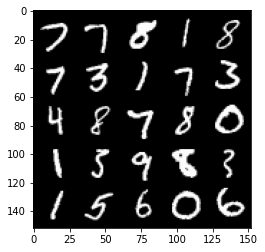

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41, step 19500: Generator loss: 0.6937065812349317, discriminator loss: 0.6936976585388179


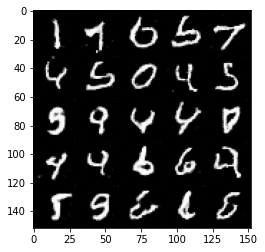

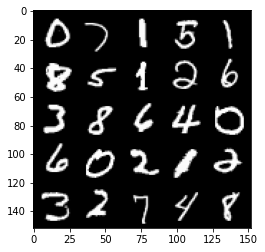

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42, step 20000: Generator loss: 0.6944347292184838, discriminator loss: 0.6936593314409264


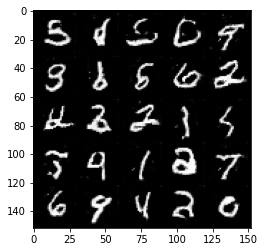

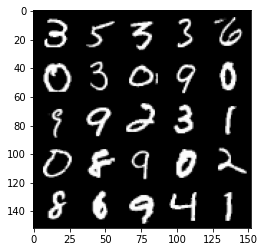

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43, step 20500: Generator loss: 0.6942406215667714, discriminator loss: 0.6936590977907184


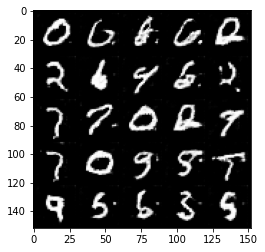

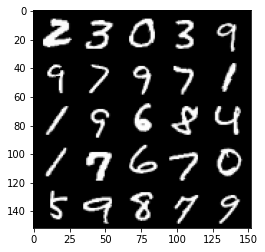

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44, step 21000: Generator loss: 0.6941096162796022, discriminator loss: 0.6936870954036711


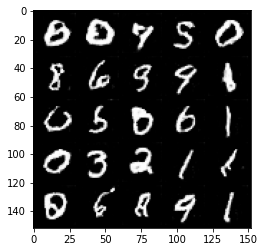

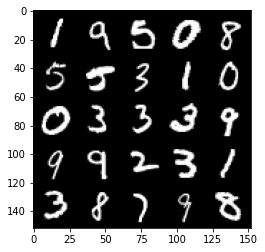

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45, step 21500: Generator loss: 0.6947340526580806, discriminator loss: 0.6935747579336168


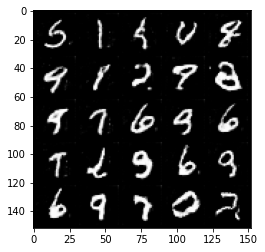

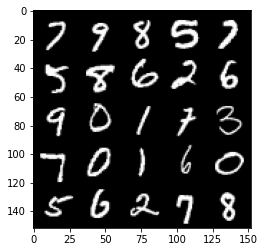

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46, step 22000: Generator loss: 0.6936777007579811, discriminator loss: 0.6935256830453871


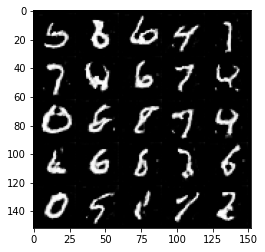

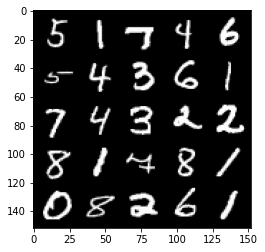

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47, step 22500: Generator loss: 0.6944786995649331, discriminator loss: 0.6936567412614824


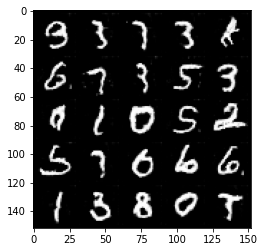

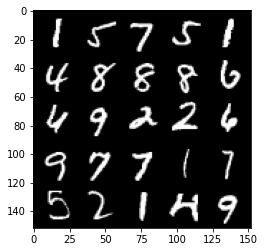

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49, step 23000: Generator loss: 0.6941179908514018, discriminator loss: 0.6935389646291734


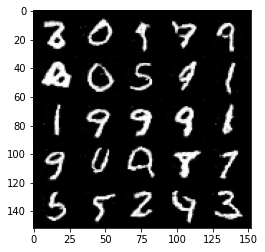

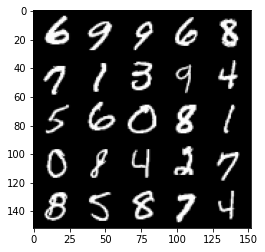

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50, step 23500: Generator loss: 0.6941855999231334, discriminator loss: 0.6934781832695005


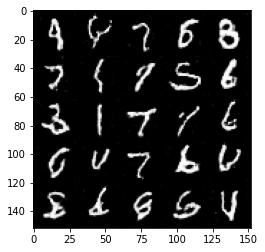

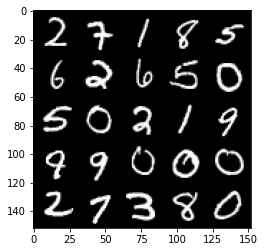

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51, step 24000: Generator loss: 0.693518586874008, discriminator loss: 0.6935016026496887


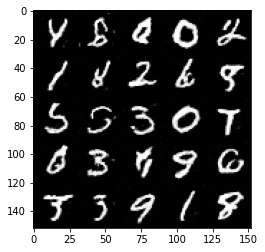

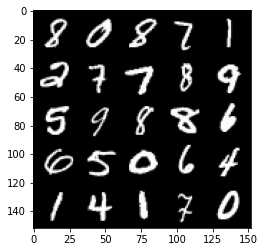

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52, step 24500: Generator loss: 0.6940780308246615, discriminator loss: 0.6934515326023097


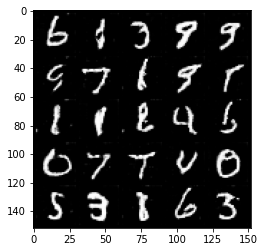

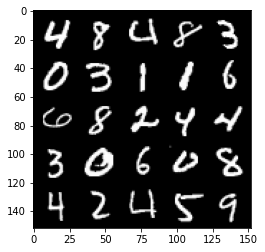

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53, step 25000: Generator loss: 0.693572375059128, discriminator loss: 0.6935431237220759


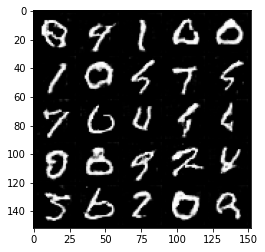

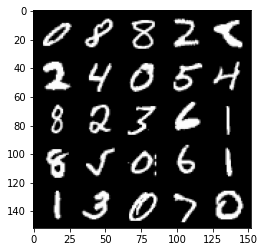

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54, step 25500: Generator loss: 0.6945476340055463, discriminator loss: 0.693515667676925


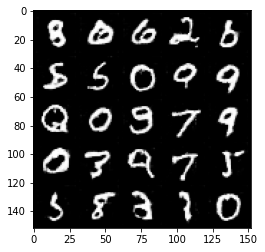

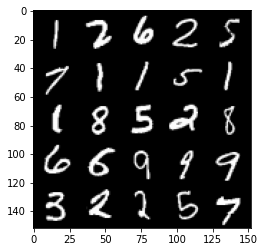

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55, step 26000: Generator loss: 0.6941519597768786, discriminator loss: 0.6933823804855346


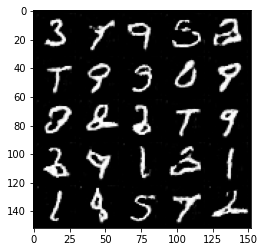

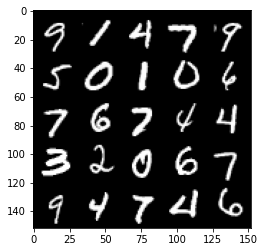

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56, step 26500: Generator loss: 0.6939055840969087, discriminator loss: 0.6933905744552609


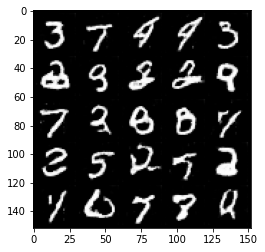

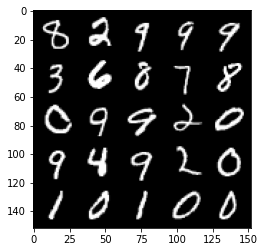

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57, step 27000: Generator loss: 0.6939528095722205, discriminator loss: 0.6934740775823599


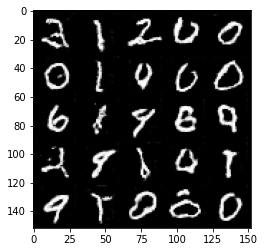

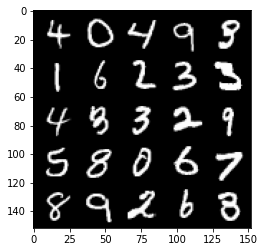

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58, step 27500: Generator loss: 0.694006767511368, discriminator loss: 0.6933622785806656


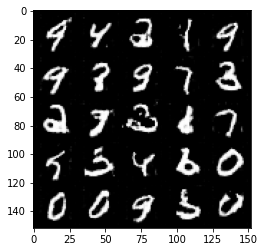

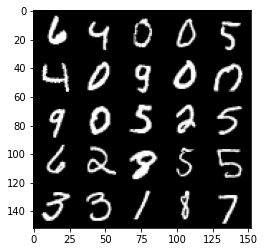

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59, step 28000: Generator loss: 0.6941033922433862, discriminator loss: 0.6934336706399917


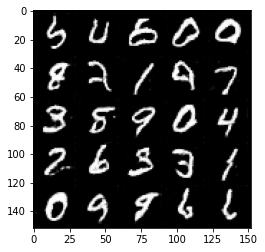

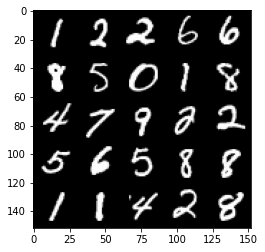

In [12]:
n_epochs = 60
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader devuelve los lotes
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Actualizar el discriminador ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Realice un seguimiento de la pérdida promedio del discriminador
        mean_discriminator_loss += disc_loss.item() / display_step
        # Actualizar los gradients
        disc_loss.backward(retain_graph=True)
        # Actualizar los optimizadores
        disc_opt.step()

        ## Actualizar el generador ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Lleve un registro de la pérdida promedio del generador
        mean_generator_loss += gen_loss.item() / display_step

        ## Código de visualización##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
